In [1]:
#importing stuff
import math
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd
import json 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from BaselineRemoval import BaselineRemoval
from sklearn.metrics import mean_squared_error

from scipy import signal
from sklearn.tree import DecisionTreeRegressor 

In [2]:
def cross_entropy(y,y_pre):
    loss=-np.sum(y*np.log(y_pre))
    return loss/float(y_pre.shape[0])

In [3]:
#Test 3 data
#Position 3 away
positionAway_w = pd.read_csv("C:\\Users\\fatem\\Desktop\\University\\FYP\\FK_dummytummy\\with water\\test3-position 3 away\\test3 with water 30-11-2021.csv", index_col = "Index")

forceTest3 = pd.read_csv("C:\\Users\\fatem\\Desktop\\University\\FYP\\FK_dummytummy\\with water\\test3-position 3 away\\force-3-ex.csv",index_col = "Reading")


<AxesSubplot:title={'center':'Test 3 Force test data'}, xlabel='Time', ylabel='Force (load)'>

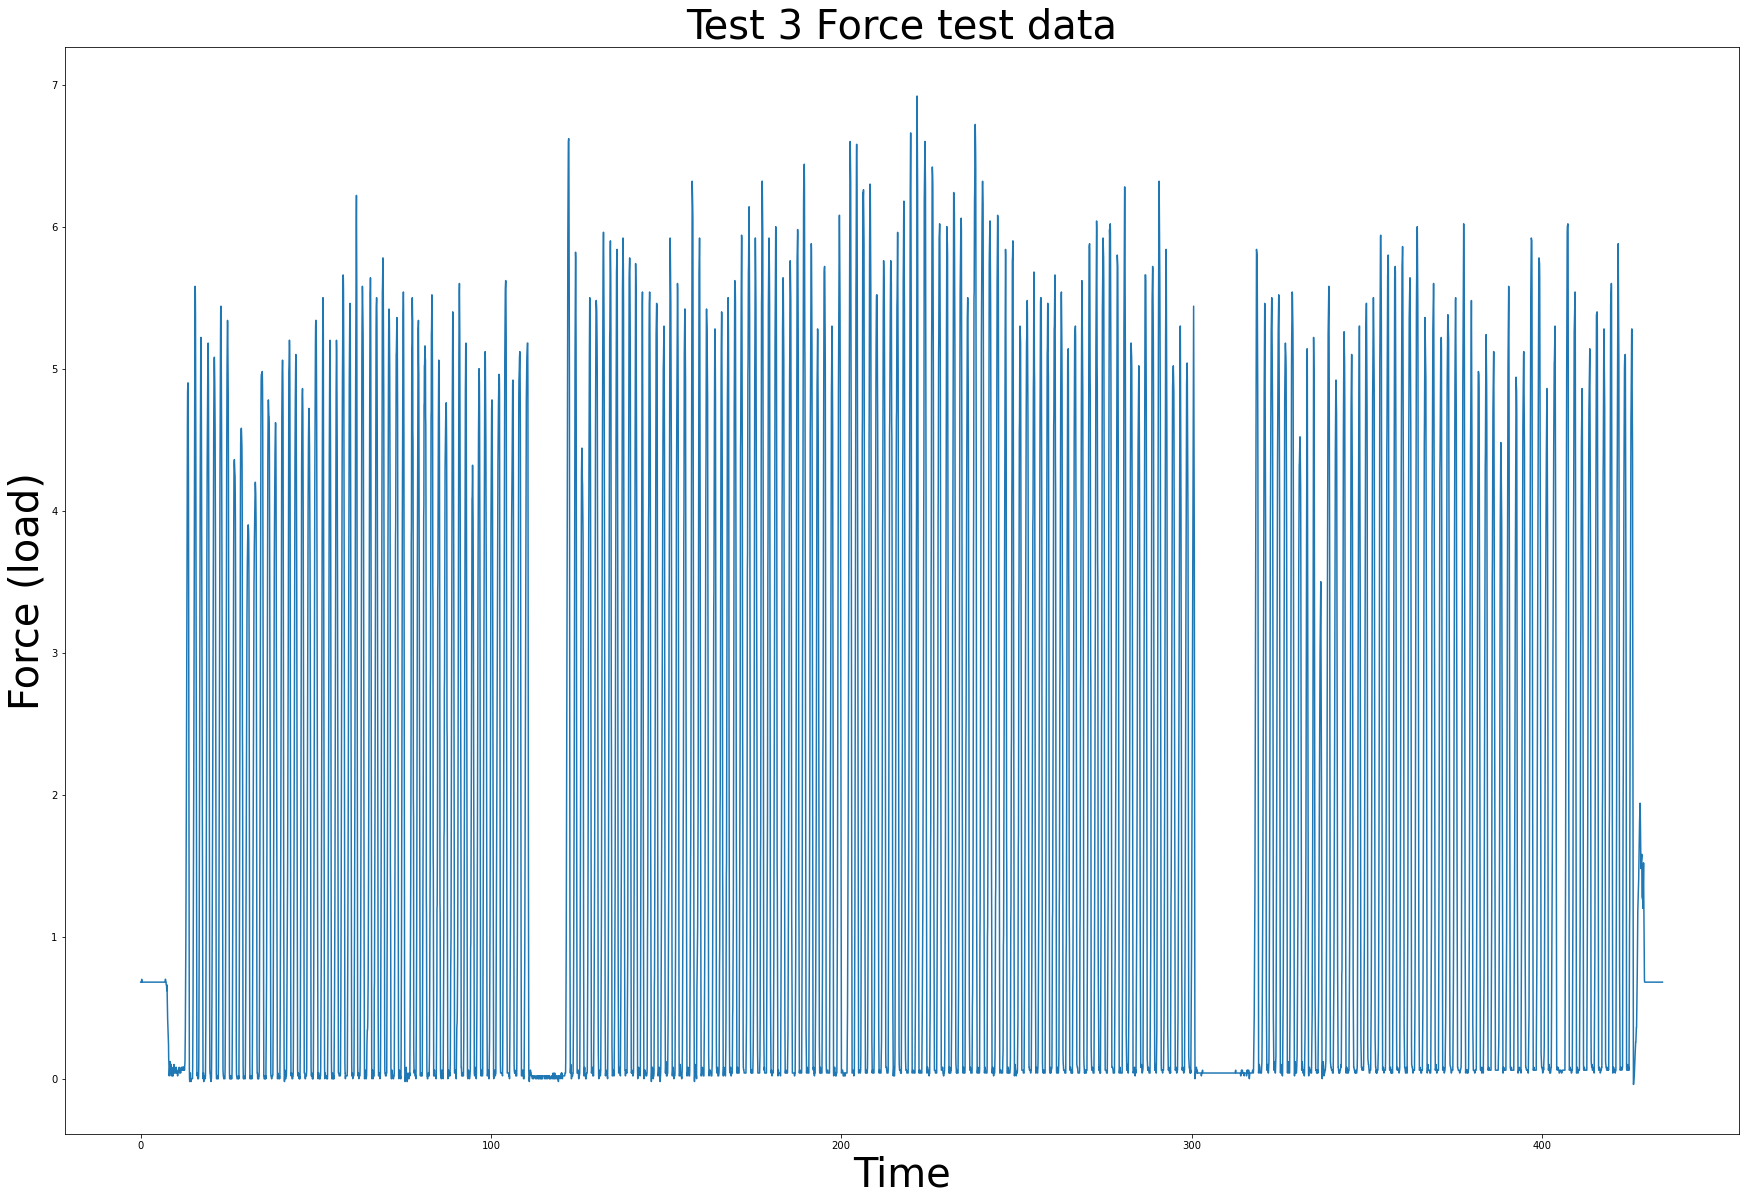

In [5]:
#Plot the data for test 3
fontsize = 40
t = forceTest3["Time"].values.reshape(-1,1)
f = forceTest3["Load"]

fig, ax = plt.subplots(figsize=(30,20))
ax.plot(t,f)




plt.title("Test 3 Force test data",fontsize = fontsize)
plt.xlabel("Time",fontsize = fontsize)
plt.ylabel("Force (load)",fontsize = fontsize)
ax


<AxesSubplot:title={'center':'Test 3 position away test per sensot with water'}, xlabel='Time', ylabel='Resistance of each sensor'>

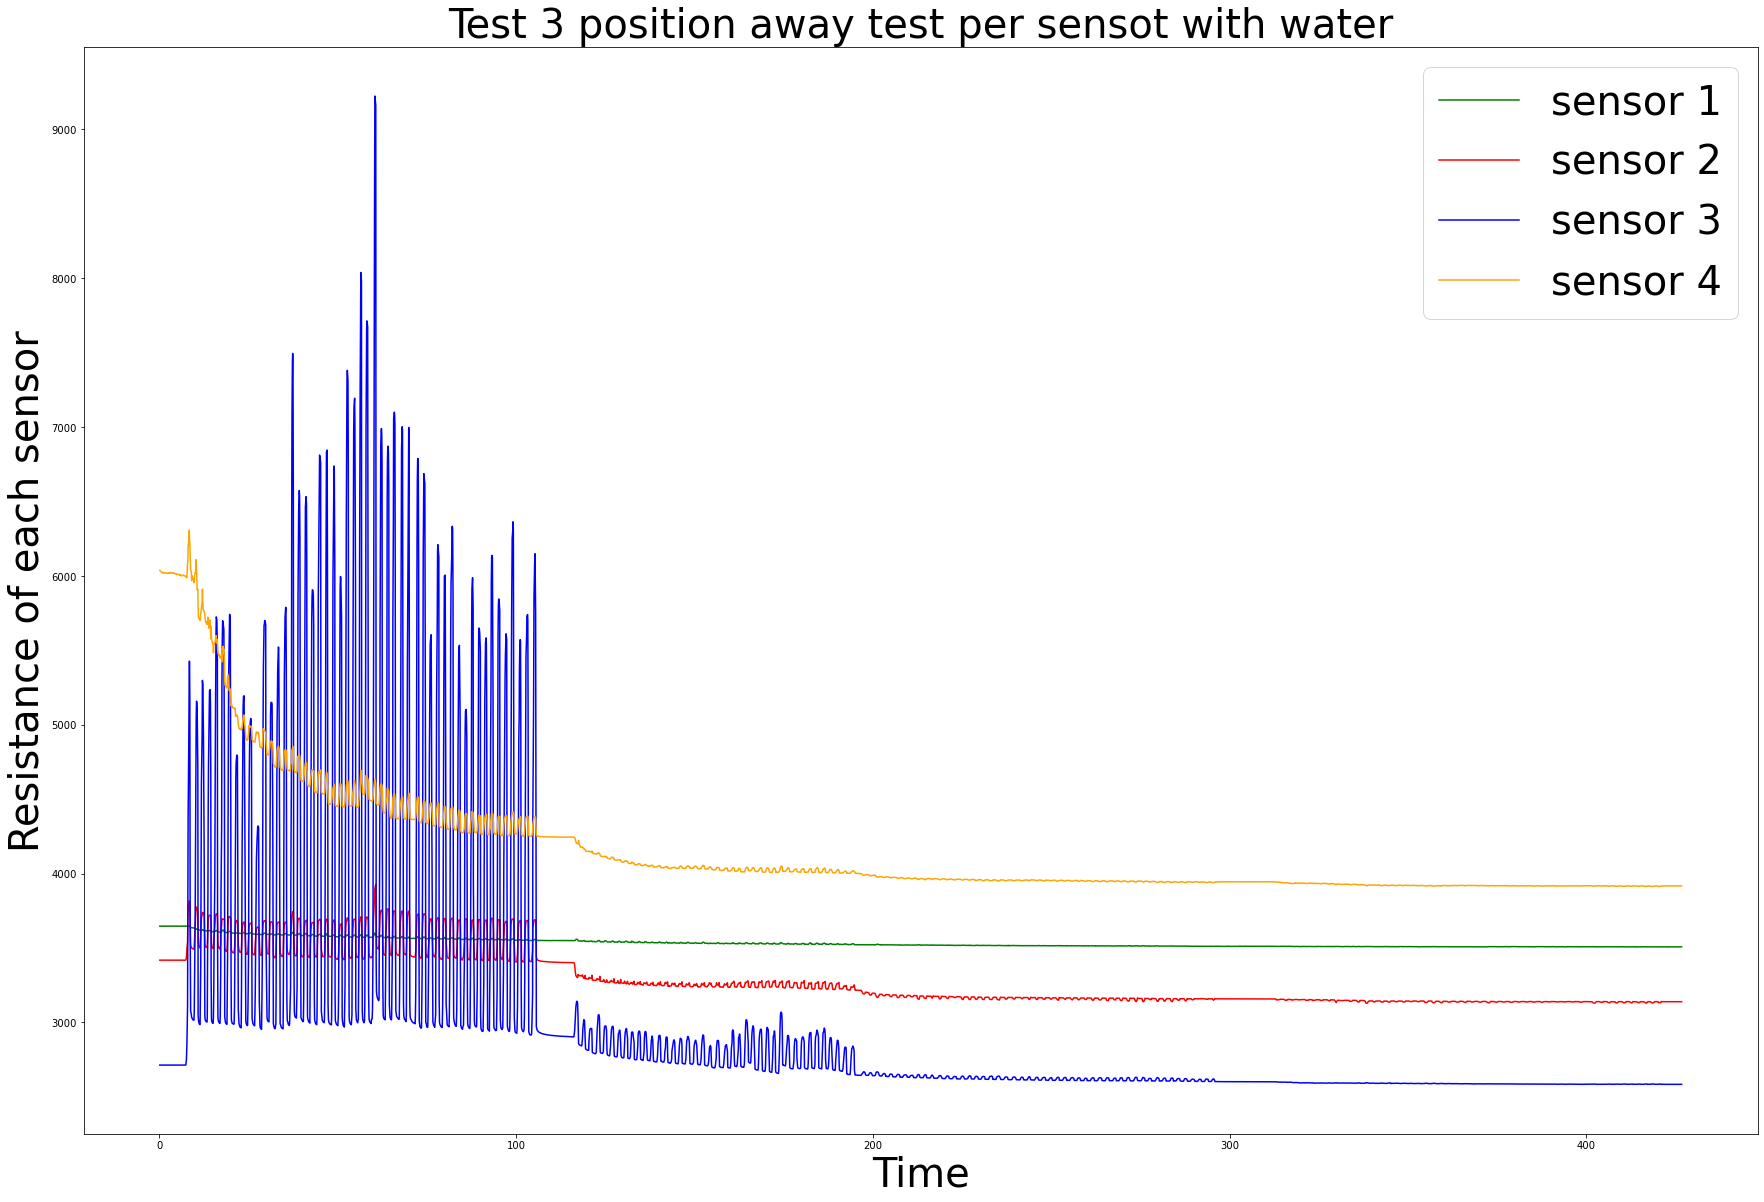

In [6]:
time= positionAway_w["SMU-1 Time (s)"].values.reshape(-1,1)

r1 = positionAway_w["SMU-1 Voltage (V)"]/positionAway_w["SMU-1 Current (A)"]
r2 = positionAway_w["SMU-2 Voltage (V)"]/positionAway_w["SMU-2 Current (A)"]
r3 = positionAway_w["SMU-3 Voltage (V)"]/positionAway_w["SMU-3 Current (A)"]
r4 = positionAway_w["SMU-4 Voltage (V)"]/positionAway_w["SMU-4 Current (A)"]

fig, ex = plt.subplots(figsize=(30,20))
ex.plot(time,r1, color = 'green', label = 'sensor 1')
ex.plot(time,r2, color = 'red', label = 'sensor 2')
ex.plot(time,r3, color = 'blue', label = 'sensor 3')
ex.plot(time,r4, color = 'orange', label = 'sensor 4')
plt.title("Test 3 position away test per sensot with water",fontsize = fontsize)
plt.xlabel("Time",fontsize = fontsize)
plt.ylabel("Resistance of each sensor",fontsize = fontsize)
ex.legend(loc = 'upper right',fontsize = fontsize)

ex

In [7]:
shifted_t = time+5
shifted_r3 = r3 - 2990
print(shifted_t.shape)
print(shifted_r3.shape)

(3542, 1)
(3542,)


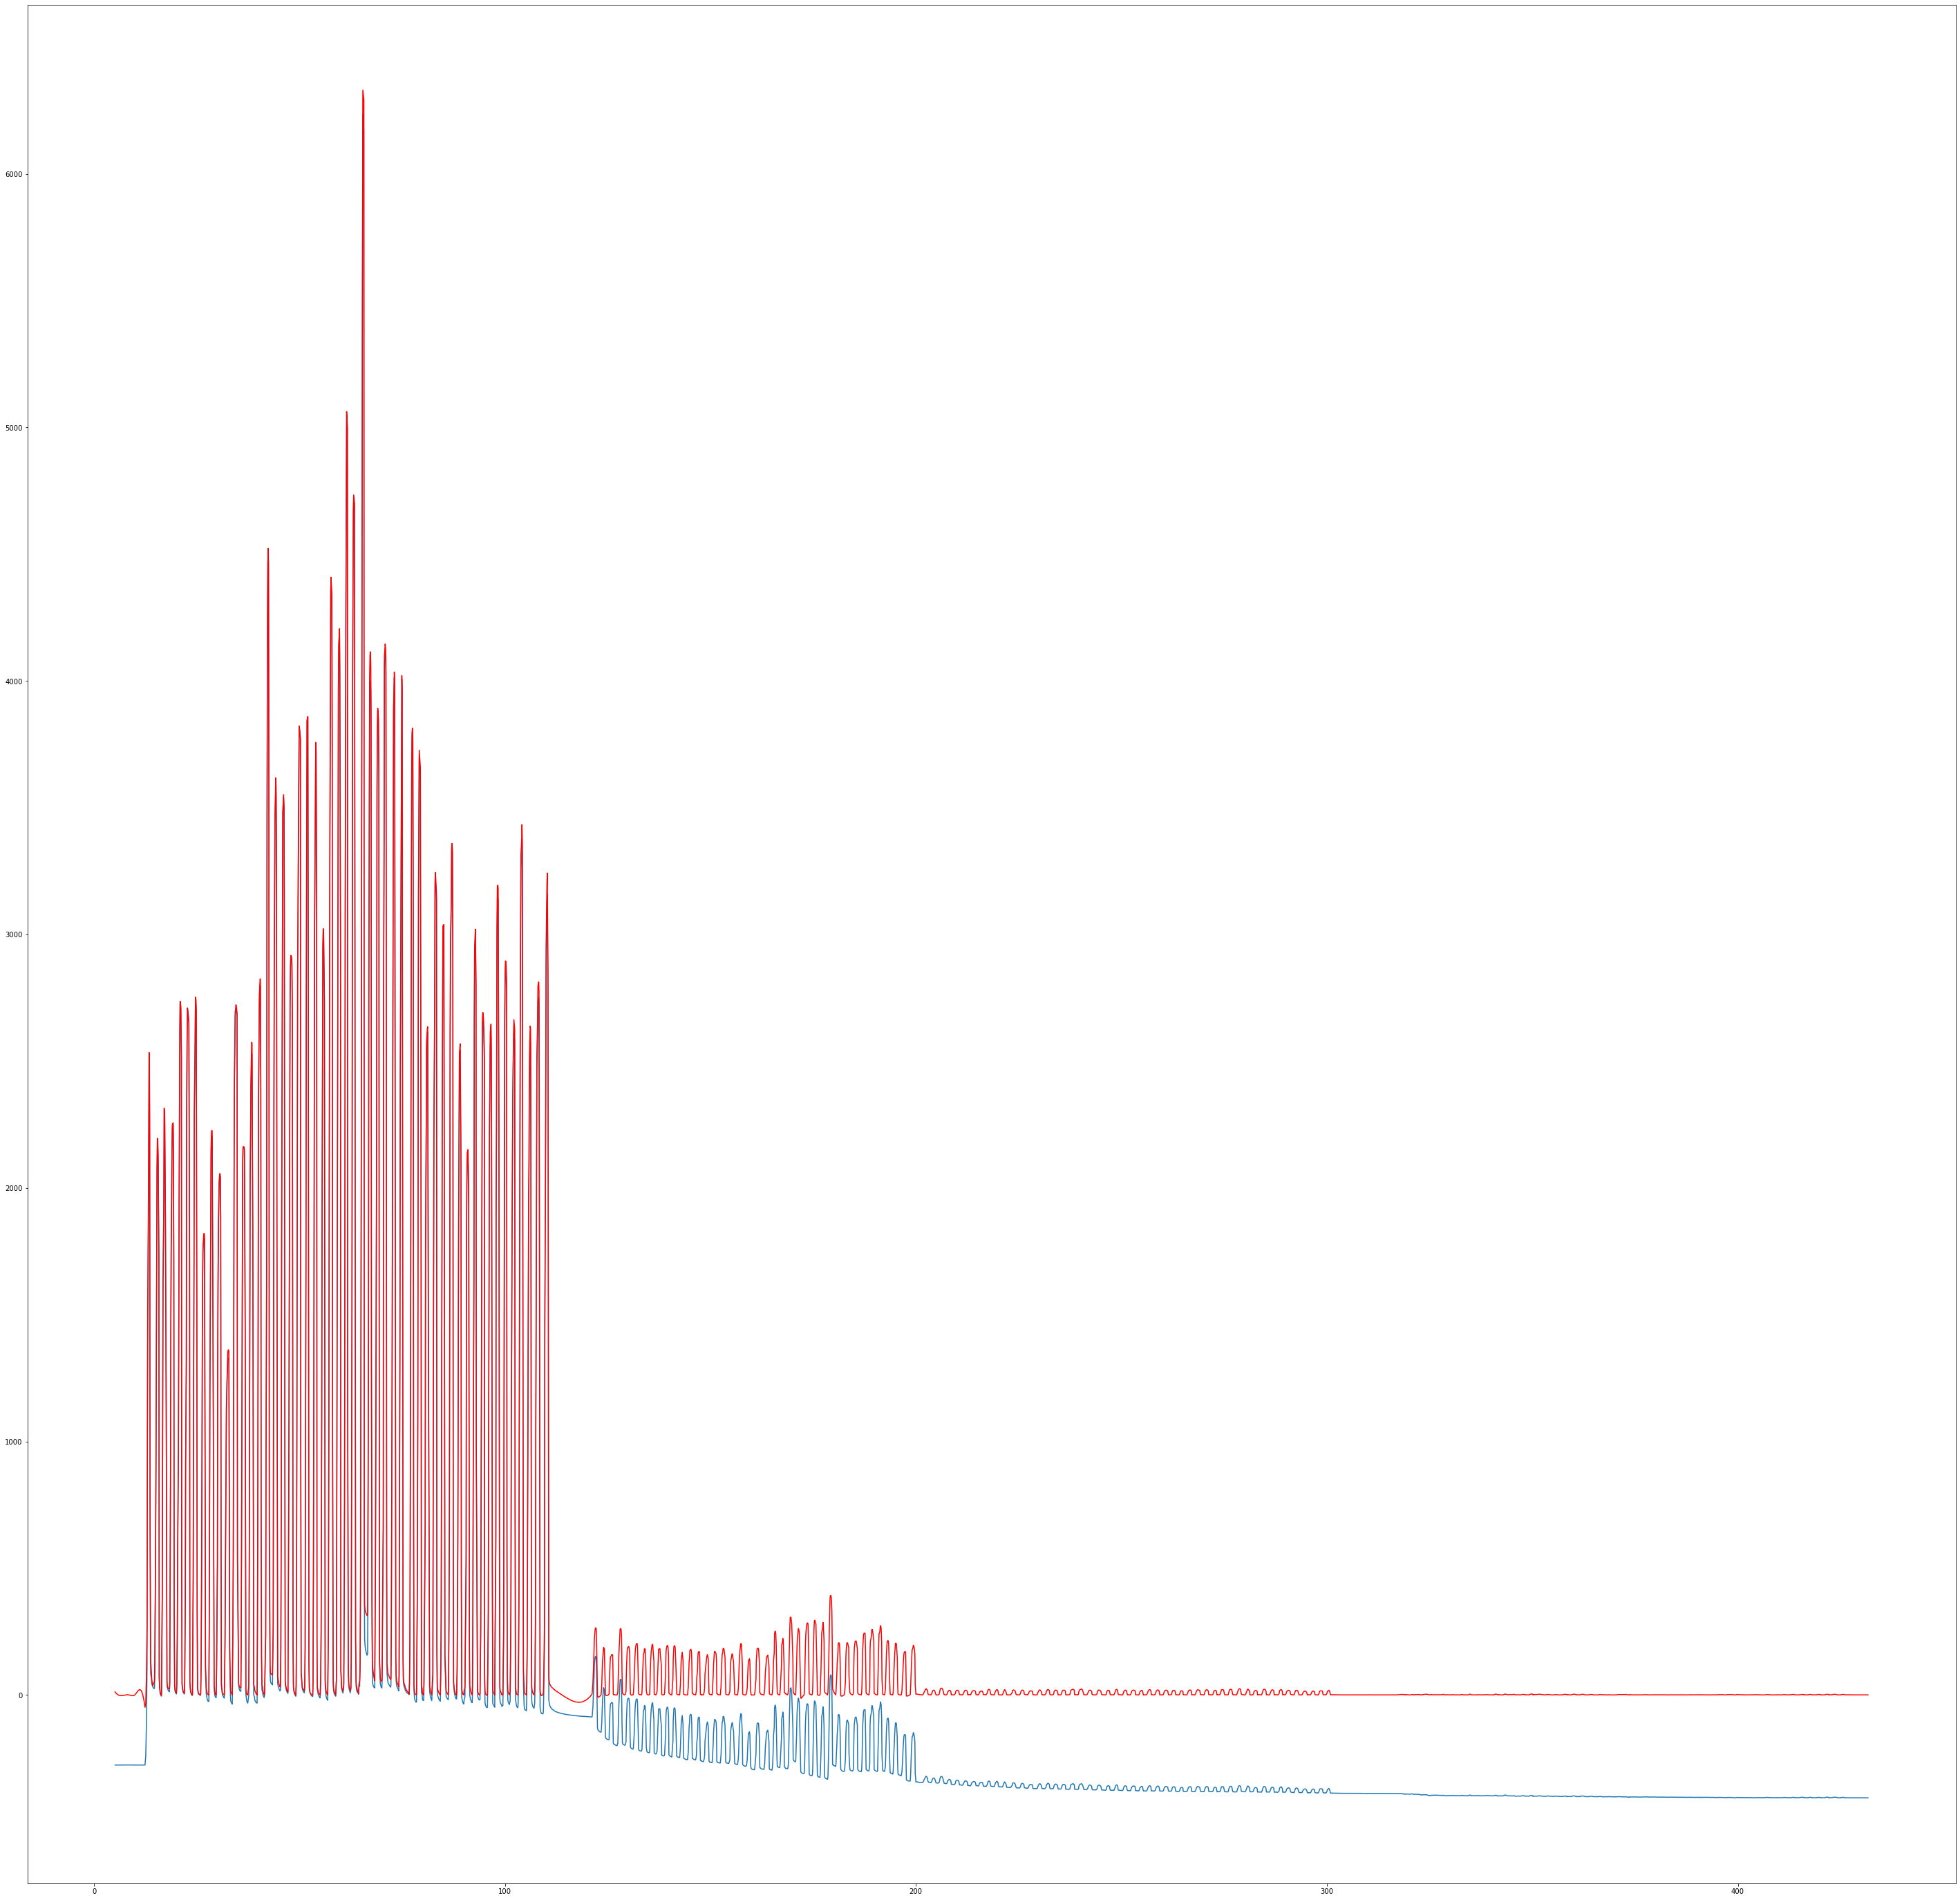

In [8]:
from scipy.signal import argrelextrema
from sklearn.preprocessing import PolynomialFeatures
from scipy import interpolate




n = 5

minimum_r3 = argrelextrema(shifted_r3.to_numpy(), np.less_equal, order = n)

minpoints = shifted_r3.iloc[minimum_r3]

s = interpolate.InterpolatedUnivariateSpline(shifted_t[minimum_r3],minpoints)

ynew = s(shifted_t)

ynew = np.reshape(ynew, (3542,))
shifted_r3_detrend = shifted_r3 + abs(ynew)

plt.figure(figsize=(50, 50))
plt.plot(shifted_t,shifted_r3)
# plt.plot(shifted_t[minimum_r3],r3_new)


plt.plot(shifted_t,shifted_r3_detrend, color= 'red')

(197,)


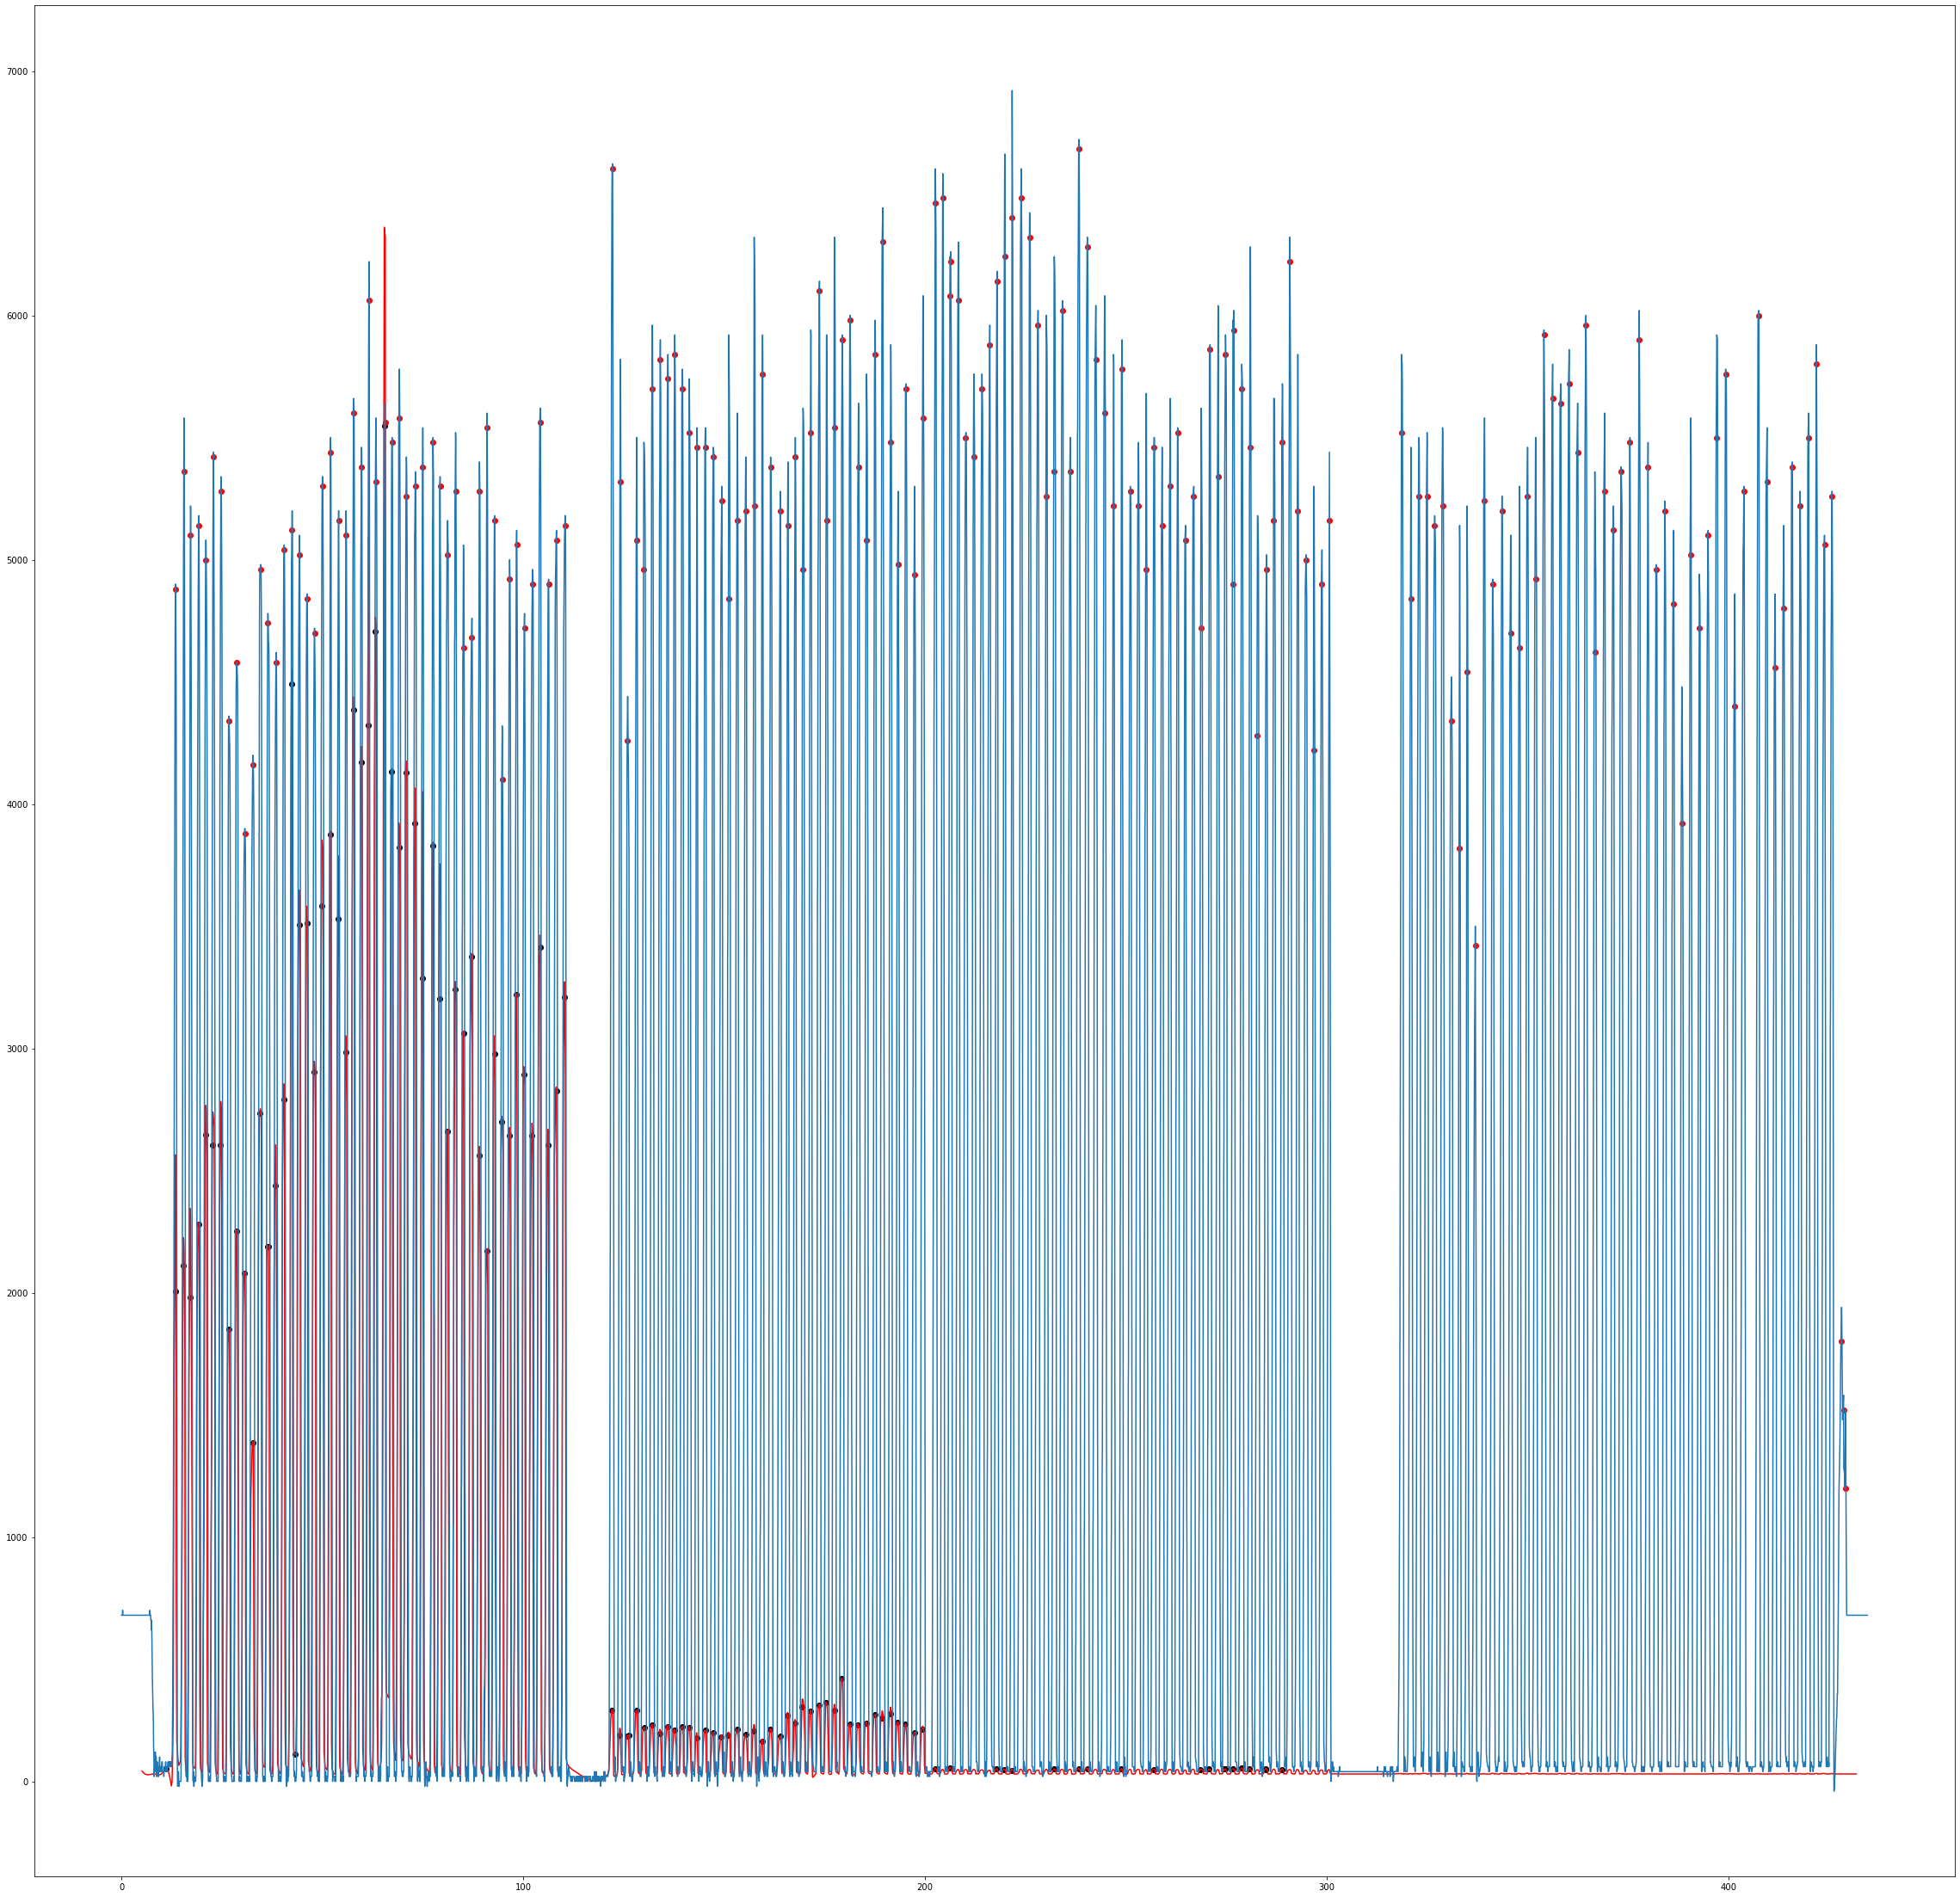

In [9]:
#Test 3?

#r3 = positionAway_w["SMU-3 Voltage (V)"]/positionAway_w["SMU-3 Current (A)"]
#time= positionAway_w["SMU-1 Time (s)"].values.reshape(-1,1)
#the resistance data to be mapped against four locations
f_scaled = np.multiply(f,1000)
shifted_r3_detrend_new = shifted_r3_detrend + 30

peaks_t3s3, _ = find_peaks(shifted_r3_detrend_new,height = 50)
peaks_t3force, _ =  find_peaks(f_scaled,height = 1500)

r3_peaks = shifted_r3_detrend_new[peaks_t3s3]
f_peaks = f_scaled[peaks_t3force]

#plotting it again
shifted_t = time+5
#shifted_r3_detrend = shifted_r3_detrend
plt.figure(figsize=(40, 40))

plt.plot(shifted_t,shifted_r3_detrend_new, color= 'red')
plt.scatter(shifted_t[peaks_t3s3],r3_peaks, color = 'black')


plt.plot(t,f_scaled)
plt.scatter(t[peaks_t3force],f_peaks, color = 'red')

print(f_peaks.shape)
#1) remove the base line 2)align the force/sensor 3) align the peaks of force and sensor 4) segmenting
#5)divide all collection of segments into train and test and train the mdoel (classification) - LSTM / RNN (time series)

In [10]:
#slicing up the data
#Slice 1 --> location number 1
slicedr3_1 = shifted_r3_detrend_new.iloc[65:890]

slicedr3_1force = f_scaled.iloc[250:2020]

n = 3
maximum_r3 = argrelextrema(slicedr3_1.to_numpy(), np.greater_equal, order = n)
maxpoints_r = slicedr3_1.iloc[maximum_r3]

In [11]:
#finding the peaks for the force data - slice 1:

m = 3
#gets a tuple of extrema:
maximum_f3 = argrelextrema(slicedr3_1force.to_numpy(), np.greater_equal, order =  m)

print(np.shape(maximum_f3)) #(183)

#indexes the extrema from the original force
maxpoints_f = (slicedr3_1force.iloc[maximum_f3])

#creates a new series (one column dataframe ) that has the same indexes from the original force
maximum_f3 = pd.Series(np.squeeze(maximum_f3),index = maxpoints_f.index)
print(np.shape(maxpoints_f)) #183

#return True or False for each max point
idx = (maxpoints_f>1000)

#Taking the ones that are true (max > 1000)
maxpoints_new = maxpoints_f[idx]
maximum_f3_new = maximum_f3[idx]

(1, 183)
(183,)


(183,)
(51,)


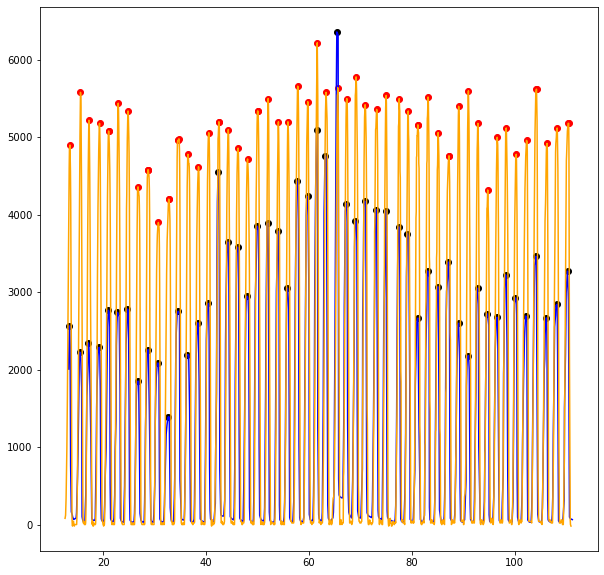

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(shifted_t[65:890],slicedr3_1, color = 'blue')
plt.plot(t[250:2020], slicedr3_1force, color = 'orange')

shiftedtime_r1 = shifted_t[65:890]
tf1 = t[250:2020]
plt.scatter(tf1[maximum_f3_new],maxpoints_new, color = 'red')
plt.scatter(shiftedtime_r1[maximum_r3],maxpoints_r, color = 'black')
print(np.shape(maxpoints_f))
print(np.shape(maxpoints_r))

In [13]:
#slicing up the data
#Slice 2 --> Location number 2
slicedr3_2 = shifted_r3_detrend_new.iloc[950:1625]

slicedr3_2force = f_scaled.iloc[2095:3220]

n2 = 3
maximum_r3_2 = argrelextrema(slicedr3_2.to_numpy(), np.greater_equal, order = n2)
maxpoints_r_2 = slicedr3_2.iloc[maximum_r3_2]


In [14]:
#Finding the peaks for the force data:
m2 = 3
#gets a tuple of extrema:
maximum_f3_2 = argrelextrema(slicedr3_2force.to_numpy(), np.greater_equal, order =  m2)

# print(np.shape(maximum_f3_2)) #(183)

#indexes the extrema from the original force
maxpoints_f2 = (slicedr3_2force.iloc[maximum_f3_2])

#creates a new series (one column dataframe ) that has the same indexes from the original force
maximum_f3_2 = pd.Series(np.squeeze(maximum_f3_2),index = maxpoints_f2.index)
# print(np.shape(maxpoints_f2)) #183

#return True or False for each max point
idx2 = (maxpoints_f2>1000)

#Taking the ones that are true (max > 1000)
maxpoints_new2 = maxpoints_f2[idx2]
maximum_f3_new2 = maximum_f3_2[idx2]

(49,)
(40,)


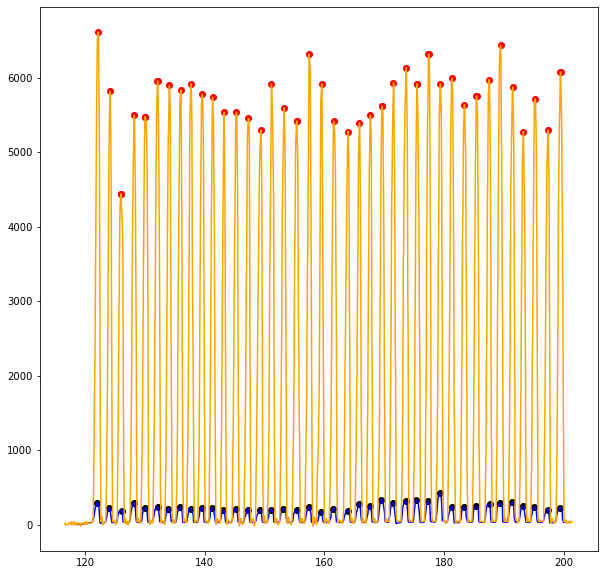

In [23]:
#Plotting slice 2
plt.figure(figsize=(10, 10))
plt.plot(shifted_t[950:1625],slicedr3_2, color = 'blue')
plt.plot(t[2095:3220], slicedr3_2force, color = 'orange')

shiftedtime_r2 = shifted_t[950:1625]
tf2 = t[2095:3220]
plt.scatter(tf2[maximum_f3_new2],maxpoints_new2, color = 'red')
plt.scatter(shiftedtime_r2[maximum_r3_2],maxpoints_r_2, color = 'black')
print(np.shape(maxpoints_new2))
print(np.shape(maxpoints_r_2))


In [16]:
#slice 3 --> Position number 3 
slicedr3_3 = shifted_r3_detrend_new.iloc[1635:2470]

slicedr3_3force = f_scaled.iloc[3220:4400]

n2 = 3
maximum_r3_3 = argrelextrema(slicedr3_3.to_numpy(), np.greater_equal, order = n2)
maxpoints_r_3 = slicedr3_3.iloc[maximum_r3_3]

In [17]:
#Finding the peaks for the force data:
m3 = 3
#gets a tuple of extrema:
maximum_f3_3 = argrelextrema(slicedr3_3force.to_numpy(), np.greater_equal, order =  m3)

# print(np.shape(maximum_f3_2)) #(183)

#indexes the extrema from the original force
maxpoints_f3 = (slicedr3_3force.iloc[maximum_f3_3])

#creates a new series (one column dataframe ) that has the same indexes from the original force
maximum_f3_3 = pd.Series(np.squeeze(maximum_f3_3),index = maxpoints_f3.index)
# print(np.shape(maxpoints_f2)) #183

#return True or False for each max point
idx3 = (maxpoints_f3>1000)

#Taking the ones that are true (max > 1000)
maxpoints_new3 = maxpoints_f3[idx3]
maximum_f3_new3 = maximum_f3_3[idx3]

(61,)
(52,)


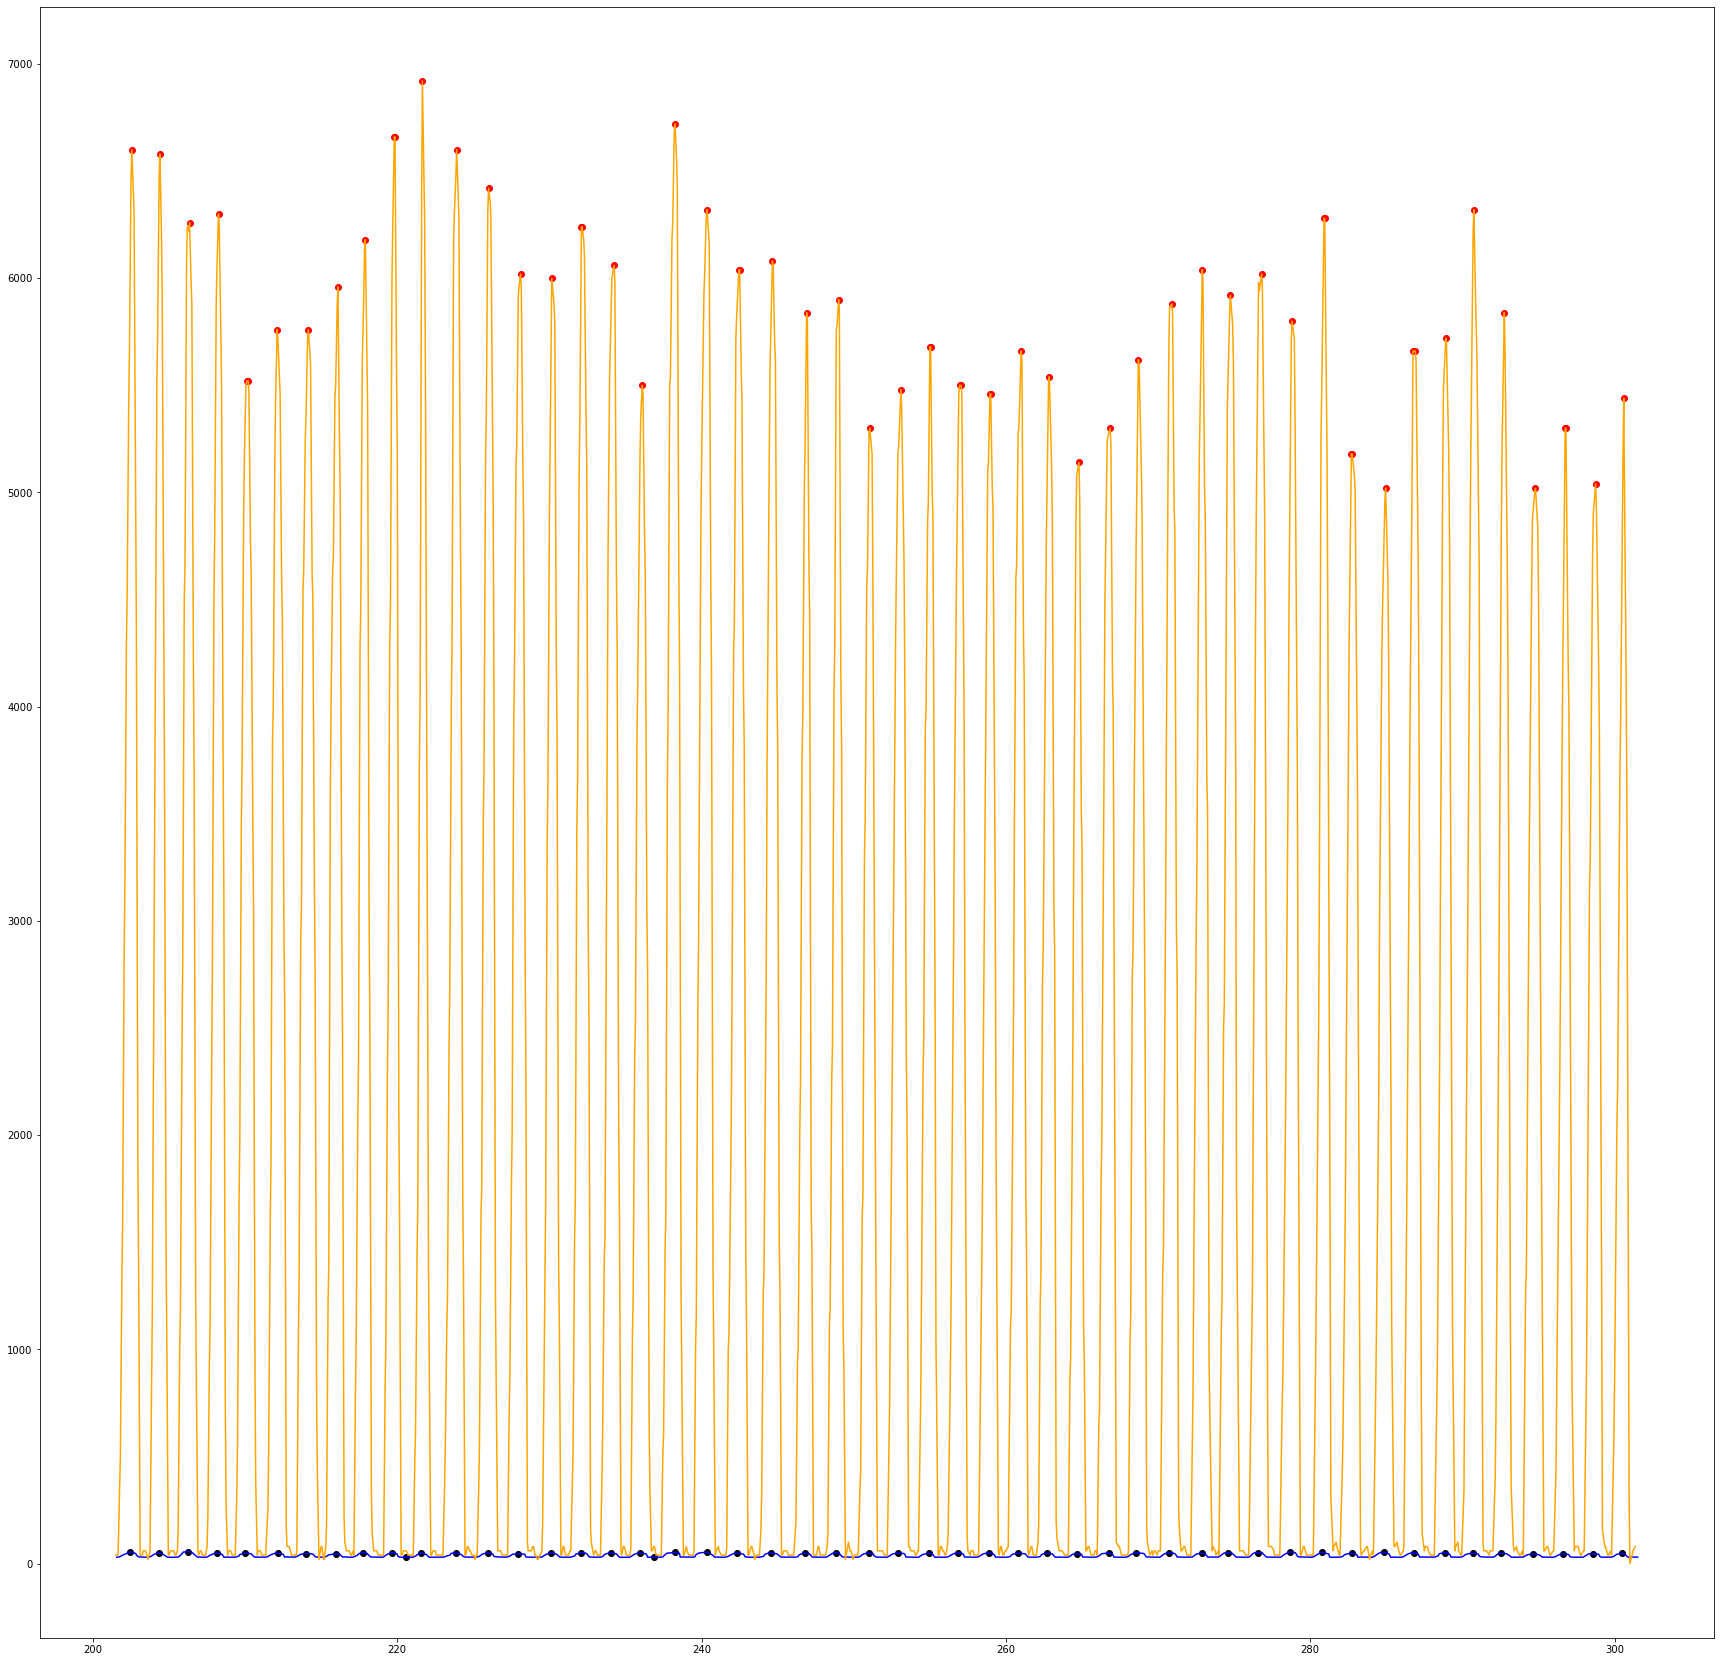

In [24]:
#Plotting slice 3
plt.figure(figsize=(30, 30))
plt.plot(shifted_t[1635:2470],slicedr3_3, color = 'blue')
plt.plot(t[3220:4400], slicedr3_3force, color = 'orange')

shiftedtime_r3 = shifted_t[1635:2470]
tf3 = t[3220:4400]
plt.scatter(tf3[maximum_f3_new3],maxpoints_new3, color = 'red')
plt.scatter(shiftedtime_r3[maximum_r3_3],maxpoints_r_3, color = 'black')
print(np.shape(maxpoints_new3))
print(np.shape(maxpoints_r_3))


In [19]:
#slice 4 --> Position number 4
print(np.shape(f_scaled))
slicedr3_4 = shifted_r3_detrend_new.iloc[2600:3542]

slicedr3_4force = f_scaled.iloc[4550:5691]

n4 = 3
maximum_r3_4 = argrelextrema(slicedr3_4.to_numpy(), np.greater_equal, order = n4)
maxpoints_r_4 = slicedr3_4.iloc[maximum_r3_4]

(5691,)


In [20]:
#Finding the peaks for the force data:
m4 = 3
#gets a tuple of extrema:
maximum_f3_4 = argrelextrema(slicedr3_4force.to_numpy(), np.greater_equal, order =  m4)

# print(np.shape(maximum_f3_2)) #(183)

#indexes the extrema from the original force
maxpoints_f4 = (slicedr3_4force.iloc[maximum_f3_4])

#creates a new series (one column dataframe ) that has the same indexes from the original force
maximum_f3_4 = pd.Series(np.squeeze(maximum_f3_4),index = maxpoints_f4.index)
# print(np.shape(maxpoints_f2)) #183

#return True or False for each max point
idx4 = (maxpoints_f4>1000)

#Taking the ones that are true (max > 1000)
maxpoints_new4 = maxpoints_f4[idx4]
maximum_f3_new4 = maximum_f3_4[idx4]

(62,)
(91,)


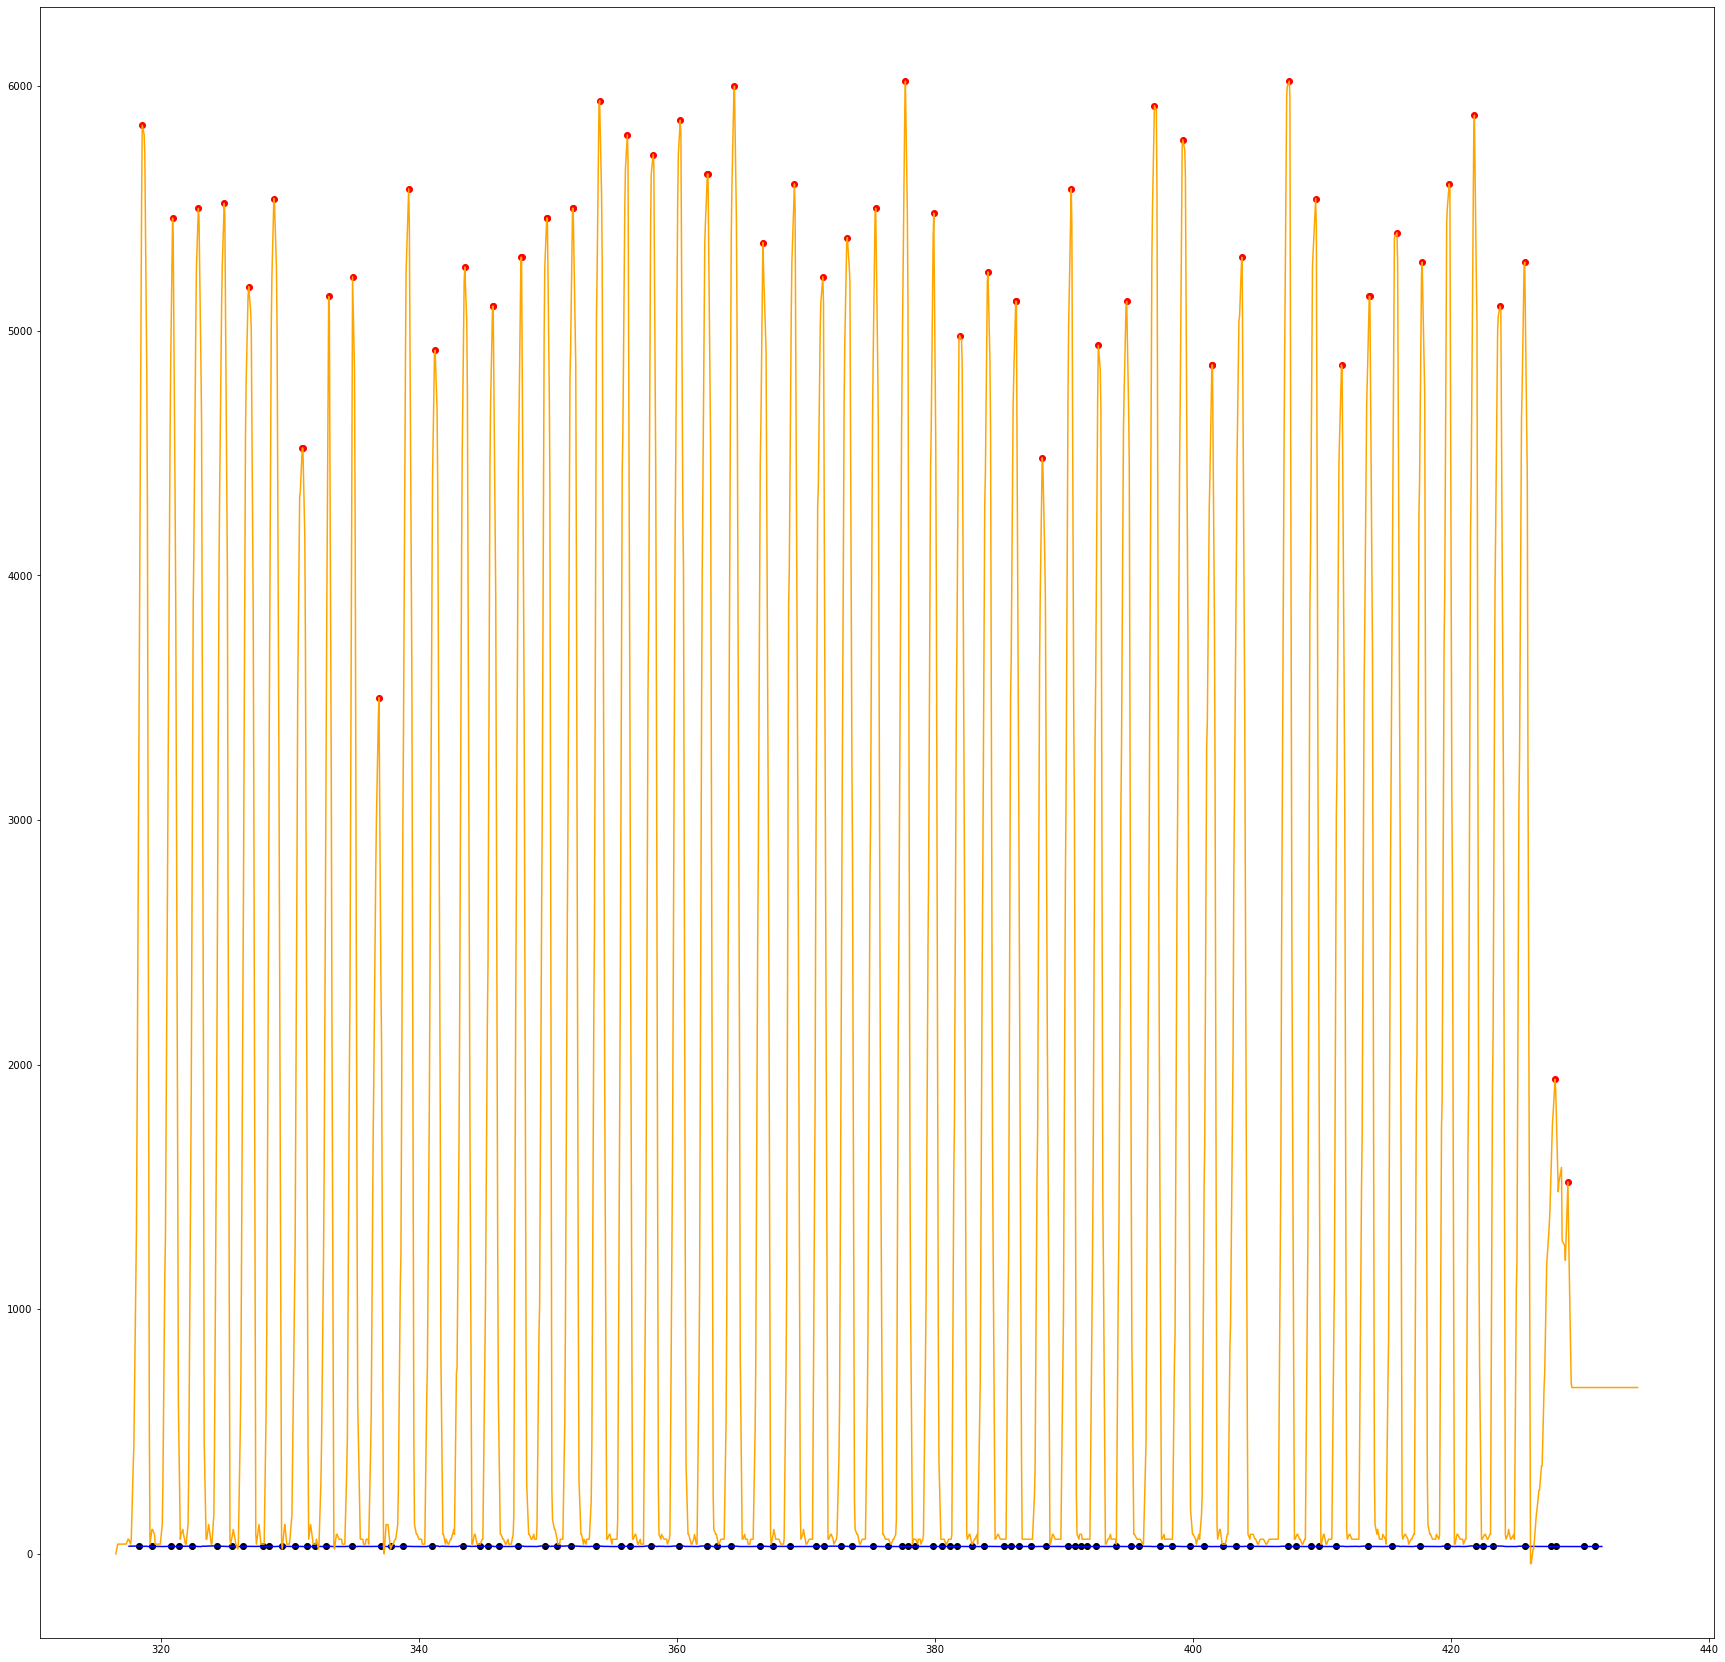

In [25]:
# Plotting slice 4
plt.figure(figsize=(30, 30))
plt.plot(shifted_t[2600:3542],slicedr3_4, color = 'blue')
plt.plot(t[4550:5691], slicedr3_4force, color = 'orange')

shiftedtime_r4 = shifted_t[2600:3542]
tf4 = t[4550:5691]
plt.scatter(tf4[maximum_f3_new4],maxpoints_new4, color = 'red')
plt.scatter(shiftedtime_r4[maximum_r3_4],maxpoints_r_4, color = 'black')
print(np.shape(maxpoints_new4))
print(np.shape(maxpoints_r_4))

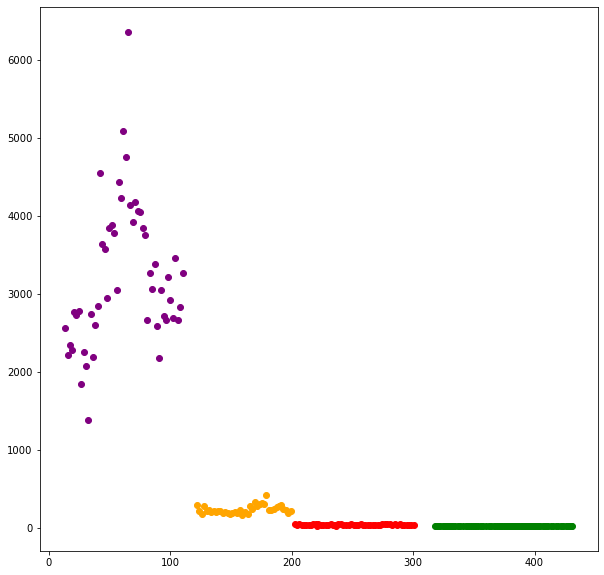

In [26]:
#Peaks/datasets
# shiftedtime_r1[maximum_r3],maxpoints_r
# tf1[maximum_f3_new],maxpoints_new
plt.figure(figsize=(10, 10))
# plt.scatter(tf1[maximum_f3_new],maxpoints_new, color = 'orange')
plt.scatter(shiftedtime_r1[maximum_r3],maxpoints_r, color = 'purple')

# shiftedtime_r1[maximum_r3_2],maxpoints_r_2
# tf1[maximum_f3_new2],maxpoints_new2
# plt.figure(figsize=(10, 10))
plt.scatter(shiftedtime_r2[maximum_r3_2],maxpoints_r_2, color = 'orange')
# plt.scatter(tf2[maximum_f3_new2],maxpoints_new2, color = 'black')

# shiftedtime_r1[maximum_r3_3],maxpoints_r_3
# tf1[maximum_f3_new3],maxpoints_new3
# plt.figure(figsize=(10, 10))
plt.scatter(shiftedtime_r3[maximum_r3_3],maxpoints_r_3, color = 'red')
# plt.scatter(tf3[maximum_f3_new3],maxpoints_new3, color = 'black')

# shiftedtime_r1[maximum_r3_4],maxpoints_r_4
# tf1[maximum_f3_new4],maxpoints_new4
# plt.figure(figsize=(10, 10))
plt.scatter(shiftedtime_r4[maximum_r3_4],maxpoints_r_4, color = 'green')
# plt.scatter(tf4[maximum_f3_new4],maxpoints_new4, color = 'black')